# Plot convergence and runtime details
Based on saved standard deviations and means from "/notebooks/simulation/Generate and Save Deviations.ipynb"

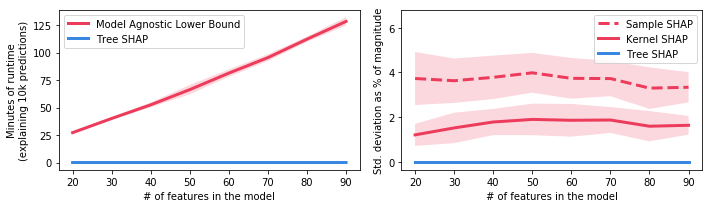

In [5]:
import xgboost
import numpy as np
import shap
import time
from tqdm import tqdm
import matplotlib.pylab as pl
from shap import KernelExplainer
from shap import SamplingExplainer
kernel_shap_std_lst = np.load("scratch/kernel_shap_std_lst.npy")
ime_std_lst = np.load("scratch/ime_std_lst.npy")
kernel_shap_m_lst = np.load("scratch/kernel_shap_m_lst.npy")
ime_m_lst = np.load("scratch/ime_m_lst.npy")

tree_shap_times_lst = []
sample_times_lst = []
N = 1000
Ms = [20,30,40,50,60,70,80,90]
for i in tqdm(range(0,30)):
    tree_shap_times = []
    sample_times = []
    for M in Ms:

        X = np.random.randn(N, M)
        y = np.random.randn(N)
        model = xgboost.train({"eta": 1, "silent":1}, xgboost.DMatrix(X, y), 1000)

        #print()
        e = shap.TreeExplainer(model)
        s = time.time()
        e.shap_values(X)
        tree_shap_times.append((time.time() - s)/1000)

        tmp = np.vstack([X for i in range(1 * M)])
        s = time.time()
        model.predict(xgboost.DMatrix(tmp))
        sample_times.append(time.time() - s)
    tree_shap_times_lst.append(tree_shap_times)
    sample_times_lst.append(sample_times)
    
kernel_ratio_mean = (np.array(kernel_shap_std_lst) / np.array(kernel_shap_m_lst)).mean(0)
kernel_ratio_std = (np.array(kernel_shap_std_lst) / np.array(kernel_shap_m_lst)).std(0)
ime_ratio_mean = (np.array(ime_std_lst) / np.array(ime_m_lst)).mean(0)
ime_ratio_std = (np.array(ime_std_lst) / np.array(ime_m_lst)).std(0)
sample_times_mean = np.array(sample_times_lst).mean(0)
sample_times_std = np.array(sample_times_lst).std(0)
ts_times_mean = np.array(tree_shap_times_lst).mean(0)
ts_times_std = np.array(tree_shap_times_lst).std(0)

f = pl.figure(figsize=(10,3))
pl.subplot(1, 2, 1)
pl.plot(
    Ms, sample_times_mean*10000 / (60),
    label="Model Agnostic Lower Bound",
    color="#ED3C5B", linewidth=3
)

pl.plot(
    Ms, np.array(tree_shap_times_lst).mean(0)*10000 / (60),
    label="Tree SHAP", color="#3888E1", linewidth=3
)

pl.fill_between(Ms,(sample_times_mean-sample_times_std)*10000 / (60), 
                (sample_times_mean+sample_times_std)*10000 / (60), 
                facecolor='#ED3C5B', alpha=.2)

pl.fill_between(Ms,(ts_times_mean-ts_times_std)*10000 / (60), 
                (ts_times_mean+ts_times_std)*10000 / (60), 
                facecolor='#3888E1', alpha=.2)

pl.ylabel("Minutes of runtime\n(explaining 10k predictions)")
pl.xlabel("# of features in the model")
pl.legend()

pl.subplot(1, 2, 2)
pl.plot(
    Ms, ime_ratio_mean*100, "--",
    label="Sample SHAP", color="#ED3C5B", linewidth=3
)
pl.plot(
    Ms, kernel_ratio_mean*100,
    label="Kernel SHAP",
    color="#ED3C5B", linewidth=3
)
pl.fill_between(Ms,(ime_ratio_mean-ime_ratio_std)*100, 
                (ime_ratio_mean+ime_ratio_std)*100, 
                facecolor='#ED3C5B', alpha=.2)

pl.fill_between(Ms,(kernel_ratio_mean-kernel_ratio_std)*100, 
                (kernel_ratio_mean+kernel_ratio_std)*100, 
                facecolor='#ED3C5B', alpha=.2)

pl.plot(
    Ms, np.zeros(len(Ms)),
    label="Tree SHAP",
    color="#3888E1", linewidth=3
)
pl.ylabel("Std. deviation as % of magnitude")
pl.xlabel("# of features in the model")
pl.ylim([-.36,6.8])
pl.legend(loc="upper right")
pl.tight_layout()
pl.savefig("perf.pdf")
pl.show()